In [1]:
%%capture
!pip install transformers --upgrade
!pip install mosestokenizer
!pip install sentencepiece
!pip install ast

In [2]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from google.colab import drive
import re
from bs4 import BeautifulSoup

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.cuda() # Puts model on GPU

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/content/drive/My Drive/English_sentiment_model.pt", map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [6]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [8]:
# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

In [9]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=torch.device('cuda'))
        tweet_attention_mask = data[1].to(device=torch.device('cuda'))
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [10]:
import pandas as pd 
import numpy as np 
import re

df = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Full/IndDiffGenerationFull.csv')
df

,rowNo,type,stimFormat,condition1,condition2,ITI,random,randomBlock,responseType,head,required,responseOptions,pageName,pageBreak,ITI_ms,timestamp,response,RT,correct,responseCode,GMT_timestamp,local_timestamp,link,age,sex,education,handedness,completionCode
0,33,form,word,Erica,NaN,NaN,NaN,6,box,Answer 1,1,NaN,You are leaving the mall on a hot summer day. ...,NaN,NaN,79073,break one of the windows,54716,0,NaN,2021-09-27_17:07:11,2021-09-27_07:07:11,https://www.testable.org/experiment/31/838087/...,41.0,female,Bachelor degree,right-handed,YX5fuO4VpL3Et7bB
1,34,form,word,Erica,NaN,NaN,NaN,6,box,Answer 2,1,NaN,You are leaving the mall on a hot summer day. ...,NaN,NaN,79073,call the police,54716,0,NaN,2021-09-27_17:07:11,2021-09-27_07:07:11,https://www.testable.org/experiment/31/838087/...,41.0,female,Bachelor degree,right-handed,YX5fuO4VpL3Et7bB
2,35,form,word,Erica,NaN,NaN,NaN,6,box,Answer 3,1,NaN,You are leaving the mall on a hot summer day. ...,NaN,NaN,79073,alert mall security,54716,0,NaN,2021-09-27_17:07:11,2021-09-27_07:07:11,https://www.testable.org/experiment/31/838087/...,41.0,female,Bachelor degree,right-handed,YX5fuO4VpL3Et7bB
3,36,form,word,Erica,NaN,NaN,NaN,6,box,Answer 4,1,NaN,You are leaving the mall on a hot summer day. ...,NaN,NaN,79073,ask a stranger for help,54716,0,NaN,2021-09-27_17:07:11,2021-09-27_07:07:11,https://www.testable.org/experiment/31/838087/...,41.0,female,Bachelor degree,right-handed,YX5fuO4VpL3Et7bB
4,37,form,word,Erica,NaN,NaN,NaN,6,box,Answer 5,1,NaN,You are leaving the mall on a hot summer day. ...,NaN,NaN,79073,call 911,54716,0,NaN,2021-09-27_17:07:11,2021-09-27_07:07:11,https://www.testable.org/experiment/31/838087/...,41.0,female,Bachelor degree,right-handed,YX5fuO4VpL3Et7bB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20094,70,form,word,BDI,Punishment Feelings,600.0,1.0,0 1,radio,______________________________________________...,1,I don't feel I am being punished.;I feel I may...,Please select the statement that is most accur...,NaN,NaN,2180203,I don't feel I am being punished.,135342,0,1.0,2021-10-21_01:26:42,2021-10-20_21:26:42,https://www.testable.org/experiment/31/838087/...,63.0,female,Bachelor degree,left-handed,1SczUqX7VCwAfGkB
20095,77,form,word,BDI,Worthlessness,600.0,1.0,0 1,radio,______________________________________________...,1,I do not feel I am worthless.;I don't consider...,Please select the statement that is most accur...,NaN,NaN,2180203,I do not feel I am worthless.,135342,0,1.0,2021-10-21_01:26:42,2021-10-20_21:26:42,https://www.testable.org/experiment/31/838087/...,63.0,female,Bachelor degree,left-handed,1SczUqX7VCwAfGkB
20096,84,form,word,BDI,Loss of Interest in Sex,600.0,1.0,0 1,radio,______________________________________________...,1,I have not noticed any recent change in my int...,Please select the statement that is most accur...,NaN,NaN,2180203,I have not noticed any recent change in my int...,135342,0,1.0,2021-10-21_01:26:42,2021-10-20_21:26:42,https://www.testable.org/experiment/31/838087/...,63.0,female,Bachelor degree,left-handed,1SczUqX7VCwAfGkB
20097,67,form,word,BDI,Past Failure,600.0,1.0,0 1,radio,______________________________________________...,1,I do not feel like a failure.;I feel more disc...,Please select the statement that is most accur...,NaN,NaN,2180203,I do not feel like a failure.,135342,0,1.0,2021-10-21_01:26:42,2021-10-20_21:26:42,https://www.testable.org/experiment/31/838087/...,63.0,female,Bachelor degree,left-handed,1SczUqX7VCwAfGkB


In [11]:
# from transformers import pipeline
# model = pipeline("sentiment-analysis", model='xlm-roberta-base')
# def predict_sentiment(text):
#    return model(text)[0].get('score')
#   # return model(text)[2]


In [12]:
bdi_options = {"Sadness": ["0 -- I do not feel sad.", "1 -- I feel sad much of the time.", "2 -- I am sad all the time.", "3 -- I am so sad or unhappy I can't stand it."],

    "Pessimism": ["0 -- I am not discouraged about my future.", "1 -- I feel more discouraged about my future than I used to be.",
        "2 -- I do not expect things to work out for me.", "3 -- I feel my future is hopeless and will only get worse."],

    "PastFailure": ["0 -- I do not feel like a failure.", "1 -- I feel more discouraged about my future than I used to",
        "2 -- As I look back I see a lot of failures.", "3 -- I feel I am a total failure as a person"],

    "LossofPleasure": ["0 -- I get as much pleasure as I ever did from the things I enjoy.", "1 -- I don't enjoy things as much as I used to.",
        "2 -- I get very little pleasure from the things I used to enjoy.", "3 -- I can't get any pleasure from the things I used to enjoy."],

    "GuiltyFeelings": ["0 -- I don't feel particularly guilty.", "1 -- I feel guilty over many things I have done or should have done.",
        "2 -- I feel quite guilty most of the time.", "3 -- I feel guilty all of the time."],

    "PunishmentFeelings": ["0 -- I don't feel I am being punished.", "1 -- I feel I may be punished.",
        "2 -- I expect to be punished.", " 3 -- I feel I am being punished."],

    "SelfDislike": ["0 -- I feel the same about myself as ever.", "1 -- I have lost confidence in myself.",
        "2 -- I am disappointed in myself.", "3 -- I dislike myself. "],

    "SelfCriticalness": ["0 -- I don't criticize or blame myself more than usual.", "1 -- I am more critical of myself than I used to be.",
    "2 -- I criticize myself for all of my faults.", "3 -- I blame myself for everything bad that happens."],

    "Crying": ["0 -- I don't cry anymore than I used to.", "1 -- I cry more than I used to.",
        "2 -- I cry over every little thing.", "3 -- I feel like crying but I can't."],

    "Agitation": ["0 -- I am no more restless or wound up than usual.", "1 -- I feel more restless or wound up than usual.",
        "2 -- I am so restless or agitated that it's hard to stay still.", "3 -- I am so restless or agitated that I have to keep moving or doing something."],

    "LossofInterest": ["0 -- I have not lost interest in other people or activities.", "1 -- I am less interested in other people or things than before.",
        "2 -- I have lost most of my interest in other people or things.", "3 -- It's hard to get interested in anything. "],

    "Indecisiveness": ["0 -- I make decisions about as well as ever.", "1 -- I find it more difficult to make decisions than usual.",
        "2 -- have much greater difficulty in making decisions than I used to.", "3 -- I have trouble making any decisions."],

    "Worthlessness": ["0 -- I do not feel I am worthless.", "1 -- I don't consider myself as worthwhile and useful as I used to.", 
        "2 -- I feel more worthless as compared to other people.", "3 -- I feel utterly worthless."],

    "LossofEnergy": ["0 -- I have as much energy as ever.", "1 -- I have less energy than I used to have.",
        "2 -- I don't have enough energy to do very much.", "3 -- I don't have enough energy to do anything. "],

    "ChangesinSleepingPattern": ["0 -- I have not experienced any change in my sleeping pattern.", "1a -- I sleep somewhat more than usual.",
        "1b -- I sleep somewhat less than usual.", "2a -- I sleep a lot more than usual.", "2b -- I sleep a lot less than usual.",
        "3a -- I sleep most of the day.", "3b -- I wake up 1-2 hours early and can't get back to sleep."],

    "Irratability": ["0 -- I am no more irritable than usual.", "1 -- I am more irritable than usual.",
        "2 -- I am much more irritable than usual.", "3 -- I am irritable all the time."],

    "ChangesinAppetite": ["0 -- I have not experienced any change in my appetite.", "1a -- My appetite is somewhat less than usual.",
        "1b -- My appetite is somewhat greater than usual.", "2a -- My appetite is much less than before.",
        "2b -- My appetite is much greater than usual.", "3a -- I have no appetite at all.", "3b -- I crave food all the time."],

    "ConcentrationDifficulty": ["0 -- I can concentrate as well as ever.", "1 -- I can't concentrate as well as usual.",
        "2 -- It's hard to keep my mind on anything for very long.", "3 -- I find I can't concentrate on anything."],

    "TirednessorFatigue": ["0 -- I am no more tired or fatigued than usual.", "1 -- I get more tired or fatigued more easily than usual.",
        "2 -- I am too tired or fatigued to do a lot of the things I used to do.", "3 -- I am too tired or fatigued to do most of the things I used to do."],

    "LossofInterestinSex": ["0 -- I have not noticed any recent change in my interest in sex.", "1 -- I am less interested in sex than I used to be.",
        "2 -- I am much less interested in sex now.", "3 -- I have lost interest in sex completely."]
}

#make a dictionary that maps scores to specific bdi options for efficiency later on (e.g., {1: "I feel sad all the time"})
bdi_dic = {}
for key in bdi_options:
    options = bdi_options.get(key)
    for option in options:
        ops = option.split("--")
        score = re.sub("[^0-9]", "", ops[0])
        text = ops[1].strip()
        bdi_dic[text] = score
#make dic for bai scoring
bai_dic = {"Not at all.":0, "Mildly but it didn't bother me much.": 1, "Moderately - it wasn't pleasant at time.": 2, "Severely - it bothered me a lot.":3}


In [13]:
bdi_dic

{'As I look back I see a lot of failures.': '2',
 'I am disappointed in myself.': '2',
 'I am irritable all the time.': '3',
 'I am less interested in other people or things than before.': '1',
 'I am less interested in sex than I used to be.': '1',
 'I am more critical of myself than I used to be.': '1',
 'I am more irritable than usual.': '1',
 'I am much less interested in sex now.': '2',
 'I am much more irritable than usual.': '2',
 'I am no more irritable than usual.': '0',
 'I am no more restless or wound up than usual.': '0',
 'I am no more tired or fatigued than usual.': '0',
 'I am not discouraged about my future.': '0',
 'I am sad all the time.': '2',
 'I am so restless or agitated that I have to keep moving or doing something.': '3',
 "I am so restless or agitated that it's hard to stay still.": '2',
 "I am so sad or unhappy I can't stand it.": '3',
 'I am too tired or fatigued to do a lot of the things I used to do.': '2',
 'I am too tired or fatigued to do most of the thi

In [14]:
participants = df.groupby("completionCode")

#map individual to their avg sent. score, where this is defined as the sum of all possibilities generated/number of such possibilites
scores = {}
#calc average sentiemnt score for each participant
for id, info in participants:
  #init certiain things 
  scores[id] = {}
  scores.get(id)['bdi'] = 0 
  scores.get(id)['bai'] = 0 
  sentiment = 0
  nums = 0
  for response in info['response']:
    #if it is a possibility generation
    if not pd.isna(response) and bdi_dic.get(response) == None and  bai_dic.get(response) == None:
      sentiment += predict_sentiment(response)
      nums += 1
    #if it is bdi response
    elif bdi_dic.get(response) != None:
      scores.get(id)['bdi'] = scores.get(id).get('bdi') + int(bdi_dic.get(response))
    #if bai response
    elif bai_dic.get(response) != None:
      scores.get(id)['bai'] = scores.get(id).get('bai') +int(bai_dic.get(response))
  sentiment /= nums 
  scores.get(id)['sentiment'] = sentiment
  scores.get(id)['beck'] = scores.get(id).get('bai') + scores.get(id).get('bdi')

ogscores = scores

In [15]:
#plot sentiment against beck
beck = []
sentiment = []
for key in scores:
  beck.append(scores.get(key).get('beck'))
  sentiment.append(scores.get(key).get('sentiment'))

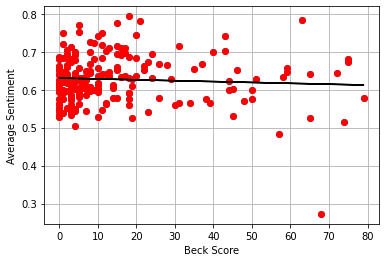

r-value:-0.065245
p-value:0.362347


In [16]:
#relationship between beck and avg. sentiment
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats

#x, y
x = np.array(beck)
y = np.array(sentiment)
plt.scatter(x, y)
plt.xlabel("Beck Score")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

In [17]:
participants = df.groupby("completionCode")
#map, to each individual, their average first scores, avg second scores, etc....
scores = {}
for id, info in participants:
  if scores.get(id) == None:
    scores[id] = {}
  responses = info.iloc[0:60, 16]
  vr = np.array_split(responses, 10)
  for part in vr:
    part = part.tolist()
    for i in range(0, len(part)):
      if scores.get(id).get(i) == None:
        if not pd.isna(part[i]):
          scores.get(id)[i] = []
          scores.get(id).get(i).append(predict_sentiment(part[i]))
      else:
        if not pd.isna(part[i]):
          scores.get(id).get(i).append(predict_sentiment(part[i]))
print(scores)


{'0fHXbalW6zgVLiwg': {0: [0.8172516226768494, 0.7827988862991333, 0.9638624787330627, 0.9102305173873901, 0.5022857785224915, 0.28368079662323, 0.9119654297828674, 0.7551811337471008, 0.6578018069267273, 0.7818959951400757], 1: [0.21063293516635895, 0.5004084706306458, 0.4037991166114807, 0.8654086589813232, 0.8132358193397522, 0.7729135155677795, 0.2808689773082733, 0.8050281405448914, 0.9362798929214478, 0.10594888031482697], 2: [0.7840979099273682, 0.6028436422348022, 0.5105430483818054, 0.9091128706932068, 0.420066237449646, 0.44770291447639465, 0.6727363467216492, 0.2568221092224121, 0.7275376319885254, 0.7575232982635498], 3: [0.7013780474662781, 0.7644070982933044, 0.6776095032691956, 0.46879369020462036, 0.44450533390045166, 0.7389086484909058, 0.7365468144416809, 0.26465079188346863, 0.8762578964233398, 0.39812931418418884], 4: [0.6691159605979919, 0.3792128562927246, 0.7937136292457581, 0.5382797122001648, 0.9495784044265747, 0.6447873115539551, 0.30518320202827454, 0.7064861

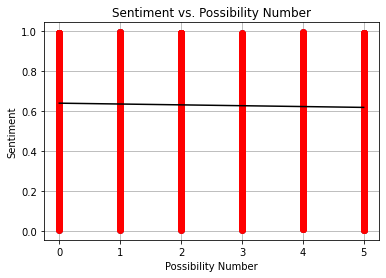

r-value:-0.028313
p-value:0.002113


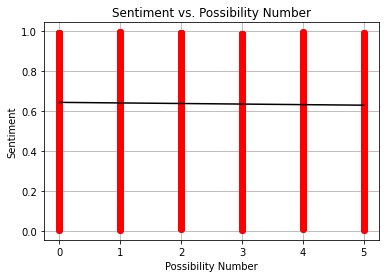

r-value:-0.019053
p-value:0.157631


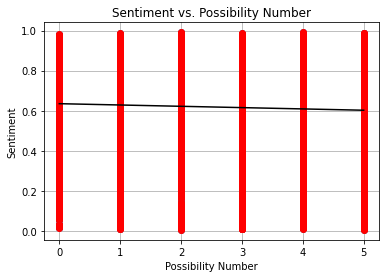

r-value:-0.043524
p-value:0.002163


In [18]:
hthresh = 10
lthresh = 5

#for both high & low beck
pnum = []
sent = []

for ind in scores:
  for p in scores.get(ind):
    for s in scores.get(ind).get(p):
      pnum.append(p)
      sent.append(s)

x = np.array(pnum)
y = np.array(sent)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#for high beck 
pnum = []
sent = []

for ind in scores:
  for p in scores.get(ind):
    for s in scores.get(ind).get(p):
      if ogscores.get(ind).get('beck') >= hthresh:
          pnum.append(p)
          sent.append(s)
x = np.array(pnum)
y = np.array(sent)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#for low beck 
pnum = []
sent = []

for ind in scores:
  for p in scores.get(ind):
    for s in scores.get(ind).get(p):
      if ogscores.get(ind).get('beck') <= lthresh:
          pnum.append(p)
          sent.append(s)
x = np.array(pnum)
y = np.array(sent)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)



In [19]:
#for medians instead of means 
globalp = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for id in scores:
  for p in scores.get(id):
    for s in scores.get(id).get(p):
      globalp.get(p).append(s)

In [20]:
avgs = {}
for ind in scores:
  if avgs.get(ind) == None:
    avgs[ind] = {}
  for score in scores.get(ind):
    avg = sum(scores.get(ind).get(score))/len(scores.get(ind).get(score))
    avgs.get(ind)[score] = avg
print(avgs)

{'0fHXbalW6zgVLiwg': {0: 0.7366954445838928, 1: 0.569452440738678, 2: 0.608898600935936, 3: 0.6071187138557435, 4: 0.6425732970237732, 5: 0.597875326871872}, '1727FYFvuGobtXXS': {0: 0.46121351756155493, 1: 0.583796215057373, 2: 0.5497023744042963, 3: 0.5848947301506996, 4: 0.42387168370187284, 5: 0.42281480208039285}, '1Pxv55J6gBK04IFj': {0: 0.7341806590557098, 1: 0.5158201921731234, 2: 0.589603266119957, 3: 0.694487202167511, 4: 0.45826244354248047, 5: 0.5878740191459656}, '1SczUqX7VCwAfGkB': {0: 0.669488613307476, 1: 0.5529692870564759, 2: 0.6129440650343895, 3: 0.5978414982557296, 4: 0.7214551702141762, 5: 0.4520936019718647}, '2r7EA4sVKkUR5rKe': {0: 0.7714055567979813, 1: 0.6530546367168426, 2: 0.6929108500480652, 3: 0.6381204128265381, 4: 0.7501354575157165, 5: 0.7050862744450569}, '3yShlLIAg5MekwWm': {0: 0.5250027686357498, 1: 0.5586734034121037, 2: 0.5594302725046874, 3: 0.4820971265435219, 4: 0.5704170972108841, 5: 0.6038227438926697}, '466xi4hTybwGbuXY': {0: 0.5349221462383866

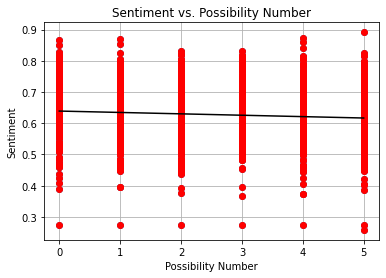

r-value:-0.078632
p-value:0.006860


In [21]:
#here we are just converting the above scores into another graph 
x = []
y = []
for id in avgs: 
  for p in avgs.get(id):
    x.append(p)
    y.append(avgs.get(id).get(p))
x = np.array(x)
y = np.array(y)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

{0: [0.7366954445838928, 0.46121351756155493, 0.7341806590557098, 0.669488613307476, 0.7714055567979813, 0.5250027686357498, 0.5349221462383866, 0.7919145435094833, 0.6015840038657189, 0.6437977731227875, 0.6450566291809082, 0.6060103386640548, 0.7489020586013794, 0.5079126179218292, 0.692932716012001, 0.47133798748254774, 0.5648038685321808, 0.6825989276170731, 0.5282428652048111, 0.6820562034845352, 0.6105897054076195, 0.721923080086708, 0.6469455420970917, 0.7271087095141411, 0.5909872829914093, 0.6881890367716551, 0.6391755975782871, 0.6026121079921722, 0.2726098597049713, 0.7160728394985199, 0.6401340529322624, 0.5936244159936905, 0.6087569296360016, 0.6580967038869858, 0.6983629882335662, 0.6188613563776016, 0.6868040576577187, 0.6103051155805588, 0.7146938025951386, 0.6184080213308334, 0.8126292109489441, 0.5670689389109611, 0.6912286669015885, 0.5162397470325232, 0.6974523097276688, 0.5822850644588471, 0.7417655616998673, 0.39065699093043804, 0.591303987801075, 0.59280938208103

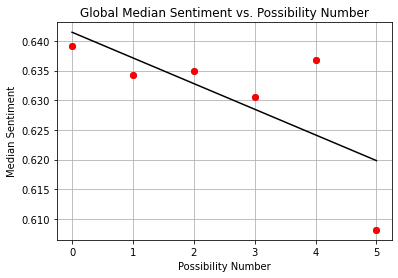

r-value:-0.710765
p-value:0.113387


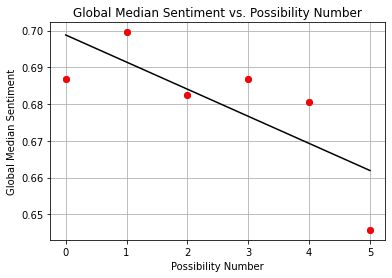

r-value:-0.758538
p-value:0.080417


In [22]:
#find the medians 
pos = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
for id in avgs:
  for p in avgs.get(id):
    pos.get(p).append(avgs.get(id).get(p))
print(pos)
medians = {}
for p in pos:
  print(p)
  mid = sorted(pos.get(p))[len(pos.get(p))//2]
  medians[p] = mid

x = []
y = []
for p in medians:
  x.append(p)
  y.append(medians.get(p))
x = np.array(x)
y = np.array(y)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Median Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Global Median Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#another manner of finding median 
medians = {}
for p in range(0,6):
  medians[p] = sorted(globalp.get(p))[len(globalp.get(p))//2]

x = []
y = []
for p in medians:
  x.append(p)
  y.append(medians.get(p))
x = np.array(x)
y = np.array(y)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Global Median Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Global Median Sentiment vs. Possibility Number")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

high beck:  [0.6347296831808213, 0.6284529055870172, 0.6280262897272818, 0.6222135363391748]
low beck:  [0.6360425054477766, 0.631753907029509, 0.6219970012394094, 0.5985424270021579]


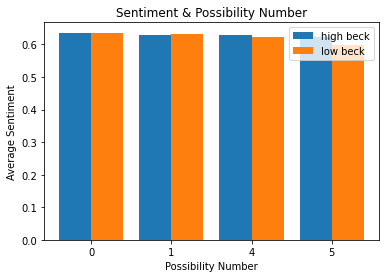

In [23]:
from math import fsum
#Here I am going to figure out what the average sentiment is for the 1st/2nd & 5th/6th possibilities generated for people with high beck & low beck 
#ALSO, JUST COMMENT OUT THE LEGEND IF YOU FEEL IT IS INTRUSIVE

high = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
low = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

for individual in avgs:
  if ogscores.get(individual).get('bdi') >= hthresh:
    for i in range(0, 6):
      high.get(i).append(avgs.get(individual).get(i))
  elif ogscores.get(individual).get('bdi') <= lthresh :
    for i in range(0, 6):
      low.get(i).append(avgs.get(individual).get(i))

#clean null values
for num in high:
  i = 0
  while i < len(high.get(num)):
    if high.get(num)[i] == None:
      high.get(num).pop(i)
    else:
      i += 1
for num in low:
  i = 0
  while i < len(low.get(num)):
    if low.get(num)[i] == None:
      low.get(num).pop(i)
    else:
      i += 1
                        
y1 = []
y2 = []
for num in high:
  high[num] = sum(high.get(num))/len(high.get(num))
  y1.append(high.get(num))
  low[num] = sum(low.get(num))/len(low.get(num))
  y2.append(low.get(num))

disp1 = y1[0:2] + y1[4:6]
disp2 = y2[0:2] + y2[4:6]
print("high beck: ", disp1)               
print("low beck: ",disp2)

#bar graph
X = [0,1,4,5]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, disp1, 0.4, label = 'high beck')
plt.bar(X_axis + 0.2, disp2, 0.4, label = 'low beck')
  
plt.xticks(X_axis, X)
plt.xlabel("Possibility Number")
plt.ylabel("Average Sentiment")
plt.title("Sentiment & Possibility Number")
plt.legend()
plt.show()

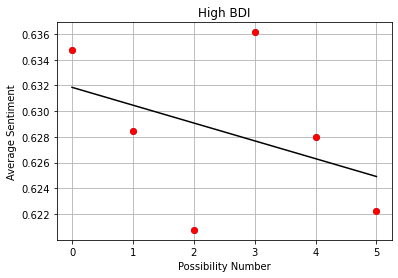

r-value:-0.413531
p-value:0.415062


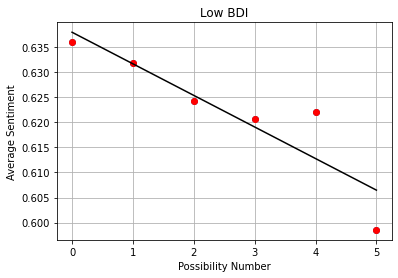

r-value:-0.903960
p-value:0.013393


In [24]:
#The scatter plot 

#high beck 
x = np.array([i for i in range(0,6)])
y = np.array(y1)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("High BDI")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#low beck
y = np.array(y2)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.title("Low BDI")
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

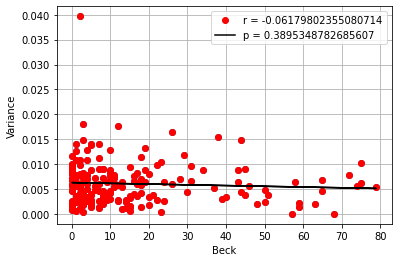

r-value:-0.061798
p-value:0.389535


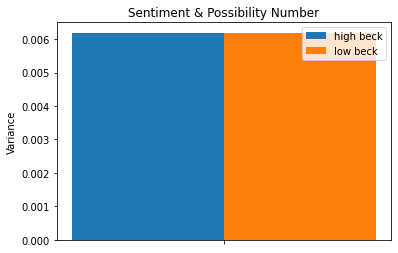

0.006191959250535686 57
0.006172446561053295 117
[0.003789541997600284, 0.0033044104487559896, 0.005460158320518337, 0.0029628607197880927, 0.007591398010969379, 0.0, 0.0015417933498986262, 0.01017161955970662, 0.0070164868174615105, 0.0061073455797472425, 0.0020751074919811412, 0.012894578010707744, 0.0043876755193052825, 0.0012910033608629745, 0.006460295065703389, 0.008809939050516842, 0.010372657260255219, 0.0058745998741769065, 0.006429669457423283, 0.0006740942793847227, 0.01173191090388107, 0.006311860610425386, 0.01140367600586993, 0.0019143516855622284, 0.00654957713740582, 0.0055143048675648084, 0.002188930135983367, 0.0041979731380205, 0.009043164496704389, 0.008917414273607623, 0.0003750439600915917, 0.0027409657505101503, 0.009589731851143804, 0.01315708172730257, 0.0033514355376526536, 0.008306584516720313, 0.016418332075193925, 0.015531025073386443, 0.0070944675546391, 0.00608831388075931, 0.005274869372120101, 0.014880281018297402, 0.008103391637112003, 0.00736360928684

In [25]:
#I want to measure the standard deviation of the avg. sentiment for possibility generations and plot that against beck here 
# but this variance is not what I had in mind. Not so much variance from the mean - but instead variance in some other measure
from statistics import variance 

#custom variance measure
def cvariance(l):
  s = 0
  for i in range(6):
    for j in range(i,6):
      s += abs(l[i] - l[j])
  return s

variation = {}
for individual in avgs:
  parray = []
  for i in range(6):
    parray.append(avgs.get(individual).get(i))
  if None not in parray:
    variation[individual] = variance(parray)

vr = []
difference = []

h = []
l = []
for individual in variation:
  #this result here is statistically significant if you set >= 25 for beck 
  if ogscores.get(individual).get('bdi') >= hthresh:
    h.append(variation.get(individual))
  elif ogscores.get(individual).get('bdi') <= lthresh:
    l.append(variation.get(individual))
  vr.append(variation.get(individual))
  difference.append(ogscores.get(individual).get('beck'))
#plot
x = np.array(difference)
y = np.array(vr)

plt.scatter(x, y)
plt.xlabel("Beck")
plt.ylabel("Variance")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.legend(["r = " + str(r_value), "p = " + str(p_value)])
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

# find the mean variance in low and high groups
hvar = sum(h)/len(h)
lvar = sum(l)/len(l)
disp1 = [hvar]
disp2 = [lvar]
X = [""]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, disp1, 0.4, label = 'high beck')
plt.bar(X_axis + 0.2, disp2, 0.4, label = 'low beck')

plt.xticks(X_axis, X)
# plt.xlabel("Possibility Number")
plt.ylabel("Variance")
plt.title("Sentiment & Possibility Number")
plt.legend()
plt.show()

print(hvar, len(h))
print(lvar, len(l))
print(h)
print(l)

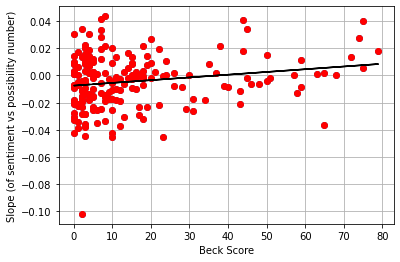

r-value:0.188277
p-value:0.008061


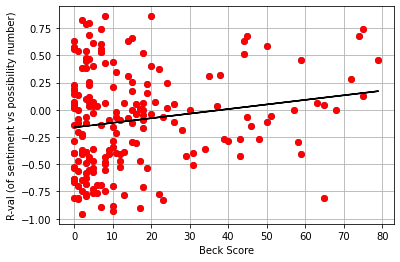

r-value:0.171563
p-value:0.015927


In [26]:

# I will try and conduct the following test here: 
# 1. Find the average possibility sentiment score for each participant. Find the slope of this plot. 
# 2. Find the beck score for each participant 
# 3. Plot slope vs bdi
# Variation: I will also run the same test but with pearson's r instead of slope...
slopes = {}
pearsons = {}
for id in avgs:
  x = []
  y = []
  for num in avgs.get(id):
    x.append(num)
    y.append(avgs.get(id).get(num))
  slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
  slopes[id] = slope
  pearsons[id] = r_value

x = []
y = []
yp = []
for id in slopes:
  x.append(ogscores.get(id).get('beck'))
  y.append(slopes.get(id))
  yp.append(pearsons.get(id))
x = np.array(x)
y = np.array(y)
plt.scatter(x, y)
plt.xlabel("Beck Score")
plt.ylabel("Slope (of sentiment vs possibility number)")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)

#second graph 
x = np.array(x)
y = np.array(yp)
plt.scatter(x, y)
plt.xlabel("Beck Score")
plt.ylabel("R-val (of sentiment vs possibility number)")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)


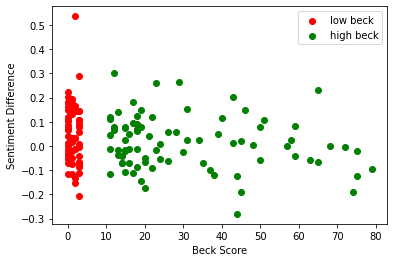

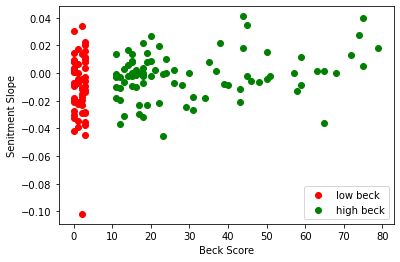

In [27]:
# I want to run some tests here about the difference in beck scores explicitly
# 1. Take high vs low beck score folks, and ask what the difference is between their 1st and 6th possibility sentiment 
#   The two groups will be beck score < 6 and beck score > 15
# 2. Do the same thing but ask about the line of best fit slope for each participant....

#g1 arrays will store the information pertaining to those with beck < 10
g1beck = []
g1diff = []
g1slope = []
#g2 arrays will store information pertaining to those with beck > 20
g2beck = []
g2diff = []
g2slope= []
for participant in avgs:
  # the number of poss averages we have - some don't have 6 for whatever reason...
  possnum = len(avgs.get(participant))
  x = []
  y = []
  for num in avgs.get(participant):
    x.append(num)
    y.append(avgs.get(participant).get(num))
  slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
  if ogscores.get(participant).get('beck') < 4:
    g1beck.append(ogscores.get(participant).get('beck'))
    g1diff.append(avgs.get(participant).get(0) - avgs.get(participant).get(possnum-1))
    g1slope.append(slope)
  elif ogscores.get(participant).get('beck') > 10:
    g2beck.append(ogscores.get(participant).get('beck'))
    g2diff.append(avgs.get(participant).get(0) - avgs.get(participant).get(possnum-1))
    g2slope.append(slope)

plt.scatter(g1beck, g1diff, c='r', label='low beck')
plt.scatter(g2beck, g2diff, c='g', label='high beck')
plt.xlabel("Beck Score")
plt.ylabel("Sentiment Difference")
plt.legend()
plt.show()

plt.scatter(g1beck, g1slope, c='r', label='low beck')
plt.scatter(g2beck, g2slope, c='g', label='high beck')
plt.xlabel("Beck Score")
plt.ylabel("Senitment Slope")
plt.legend()
plt.show()

In [28]:
globalavgs = {}
for ind in avgs:
  for score in avgs.get(ind):
    if globalavgs.get(score) == None:
      globalavgs[score] = [avgs.get(ind).get(score)]
    else:
      globalavgs.get(score).append(avgs.get(ind).get(score))

for i in range(0, len(globalavgs)):
    globalavgs[i] = sum(globalavgs[i])/len(globalavgs[i])

# should note at this point that there are far fewer answers for the fourth, fifth, and sixth answers so it is skewed. 
print(globalavgs)

{0: 0.6369438647112909, 1: 0.6344746195990116, 2: 0.6278792771212153, 3: 0.6301144887611841, 4: 0.6292800945437844, 5: 0.608393839716541}


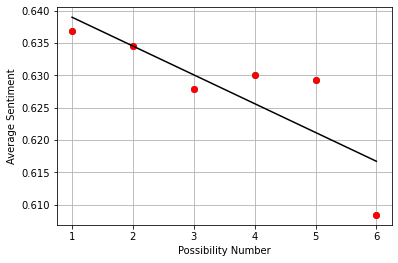

r-value:-0.824304
p-value:0.043592


In [32]:
#some of the generation trajectories
idx = [i for i in range(0, 6)]
values = [0 for i in range(0, 6)]
for key in globalavgs:
  values[key] = globalavgs.get(key)


x = np.array(idx) + 1
y = np.array(values)

plt.scatter(x, y)
plt.xlabel("Possibility Number")
plt.ylabel("Average Sentiment")

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
predict_y = intercept + slope * x

plt.plot(x,y,'ro')
plt.plot(x, predict_y, 'k-')
plt.autoscale(True)
plt.grid(True)
plt.show()

print("r-value:%f" % r_value)
print("p-value:%f" % p_value)


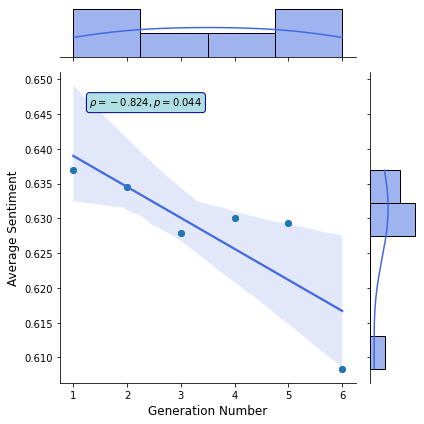

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

# a = np.random.rand(10)
# b = a * 2 + a ** 5

# print("The Rho is {}".format(np.corrcoef(a, b)[0][1]))

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [31]:

i = 0
for id,g in df.groupby("completionCode"):
  i += 1
  print(i)

#n = 197

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
